# Advanced Data Science for Transport Engineering for Coding the Curbs
In this Jupyter notebook we present our model we build for Coding the Curbs. The model is a XGBoost model that is optimized for one specific smartzone, namely Neude in Utrecht. It is possible to rerun the model for a different smartzone, however the parameters are not optimized for different smartzones, but the weights will update accordingly. 

At each block of code there will be an explanation of what is happening and how the model can be changed to your liking and at the bottom of the notebook there is a low quality interface that can be integrated into the dashboard of Coding the Curbs. 

If you want to run the model you should first import all of the used libraries. This can be done by running the line below in your terminal. 

pip install -r requirements.txt

### Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib.dates as mdates
import shap
import ipywidgets as widgets

from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import display, clear_output


These are some helper functions that retrieve or filter data on the sensors, locations and date, making it easier to analyze and visualize specific subsets of the dataset.

In [2]:
def get_sensors(location, data):
    """Assumes 'sensor' column exists with sensor IDs/names"""
    df = data[data["location name"] == location]
    return df['sensor id'].unique()
def get_locations(data):
    return data["location name"].unique()
def filter_by_location(location, data):
    return data[data['location name'] == location]
def filter_by_sensors(sensor, data):
    return data[data['sensor id'] == sensor]
def filter_by_date(data, date):
    """
    Filter data between start_date (00:00) and end_date (+1 day).
    If the input date is earlier than the earliest date in data,
    print a message and return an DataFrame filtered by the earliest date.
    """
    start_date = pd.to_datetime(date)
    
    if isinstance(data["date"].dtype, pd.DatetimeTZDtype):
        data["date"] = data["date"].dt.tz_localize(None)
    min_date = data["date"].min()  # The earliest date
    
    if start_date + pd.Timedelta(days=1) <= min_date:  
        print(f"No data available for {start_date.date()}.")
        print(f"The earliest available date is {min_date.date()}.")

    end_date = start_date + pd.Timedelta(days=1)
    return data[(data["date"].dt.date >= start_date.date()) &
                (data["date"].dt.date <= end_date.date())]

These helper functions create datasets depending on the amount of sensors there are in a specific smartzone.

In [3]:
def get_data_multiple_sensors(sensors, dataset):  
    results = {}
    for sensor in sensors:
        data = filter_by_sensors(sensor, dataset).copy()
        data['status'] = data['status'].astype(int)
        data = data.sort_values('date')
        data = data.drop_duplicates(subset='date', keep='first')
        data = data.set_index('date').resample('15min').ffill().reset_index()
        data['day_of_week'] = data['date'].dt.dayofweek
        data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
        results[sensor] = data

    return results

def get_merged_df(dataset_sensors):
    merge_dfs = []
    for sensor_id, df_sensor in dataset_sensors.items():
        df_temp = df_sensor[['date', 'status', 'slot']].copy()
        df_temp = df_temp.rename(columns={'status': f'sensor_{sensor_id}'})
        merge_dfs.append(df_temp)
    merged_df = merge_dfs[0]
    for df_next in merge_dfs[1:]:
        merged_df = pd.merge(merged_df, df_next, on=['date', 'slot'], how='outer')
    # Fill in nan
    merged_df = merged_df.sort_values('date').ffill().fillna(False)
    # Calculate occupancy
    sensor_cols = [col for col in merged_df.columns if col.startswith('sensor_')]
    merged_df[sensor_cols] = merged_df[sensor_cols].astype(int)
    merged_df['status'] = merged_df[sensor_cols].sum(axis=1) / len(sensor_cols)
    
    return merged_df

## Dataset and Smartzone Selection
Here we select the dataset and smartzone we will use during the training of our model. Also the plots gets generated for the smartzone selected. 
You can change the smartzone to any of the smartzones that are present in the data: Lange Viestraat, Stadhuisplein, Domplein, 't Wed, Neude and Beurskwartier. The rest of the project should automatically change everything depending on it. 

In [4]:
data_sensors_path = '../Sensor data Utrecht.csv'     # Here you can specify which dataset you want to use
data_sensors = pd.read_csv(data_sensors_path, delimiter=';')

# Convert Timestamp column to datetime
data_sensors['date'] = pd.to_datetime(data_sensors['date'], errors='coerce', utc=True)

smartzone = "Neude"    # Smartzones in Utrecht in this dataset are: Lange Viestraat, Stadhuisplein, Domplein, 't Wed, Neude and Beurskwartier.
# smartzone = "Lange Viestraat" # run this to show the heatmap with the multiple sensors
dataset = data_sensors
sensors = get_sensors(smartzone, dataset)
data_sensors = get_data_multiple_sensors(sensors, dataset).copy()
data = get_merged_df(data_sensors)

# Data Visualization
Now we will visualize the data we used with some lineplots, heatmaps and boxplots. 

First the lineplot of the average occupancy of one day in the selected smartzone. 

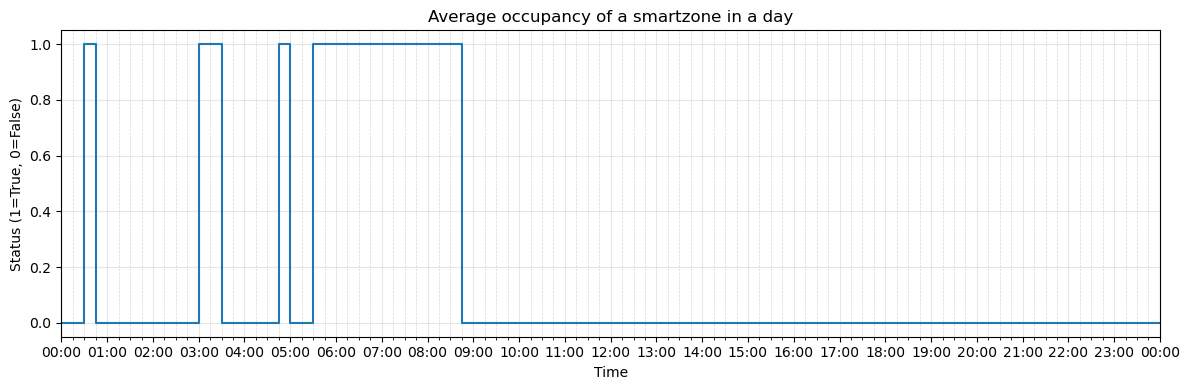

In [5]:
def plot_sensor_status(date, data):
    data = filter_by_date(data, date)
    fig, ax = plt.subplots(1, 1, figsize=(12,4), sharex=True)
    ax.step(data["date"], data["status"].astype(float))
    # Major ticks every hour
    fig.gca().xaxis.set_major_locator(mdates.HourLocator())
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # Limit x axis between 0:00 and 24:00
    start = pd.to_datetime(date).replace(hour=0, minute=0, second=0)
    end = start + pd.Timedelta(days=1)
    ax.set_xlim(start, end)
    # Minor ticks every 15 minutes
    fig.gca().xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
    # Show grid for both major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth=0.8)
    ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_title(f"Average occupancy of a smartzone in a day")
    ax.set_xlabel("Time")
    ax.set_ylabel("Status (1=True, 0=False)")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
date = '2024-10-18' # Here you can specify what date you want to visualize
plot_sensor_status(date, data)

This heatmap shows the average occupancy pattern across all available data, aggregated by the day of the week and 15-minute time intervals. It represents the typical weekly trend for the selected smartzone, based on its full dataset.

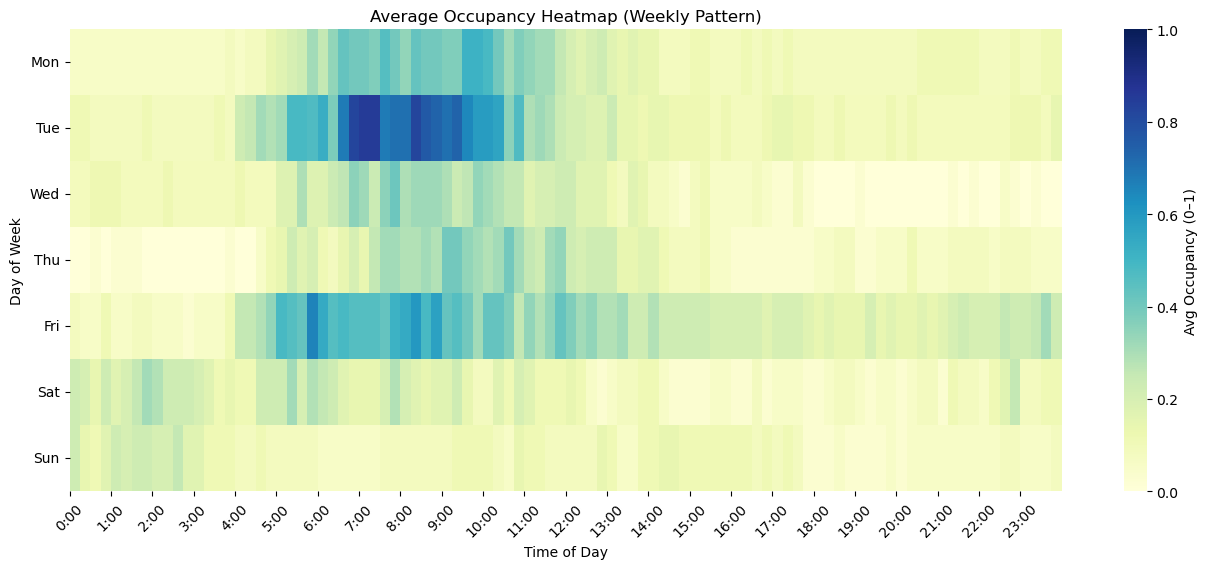

In [6]:
heatmap_data = data
heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek

heatmap_data = heatmap_data.groupby(['day_of_week','slot'])['status'].mean().unstack()
heatmap_data = heatmap_data.astype(float)  # force numeric

plt.figure(figsize=(16,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label':'Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")
xticks = np.arange(0, 96, 4)
xlabels = [str(i) + ":00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.show()

This heatmap visualizes how the occupancy of the smartzone varies throughout the week, using 15-minute intervals and three occupancy categories. The goal of this plot is to give an intuitive overview of when the area is typically busy or quiet, helping to identify time periods where logistical drivers, users of the Coding the Curbs booking system, are more or less likely to find available space. Green areas indicate less than 30% occupancy (high availability), orange areas represent 30–60% occupancy (moderate availability), and red areas show over 60% occupancy (limited availability).

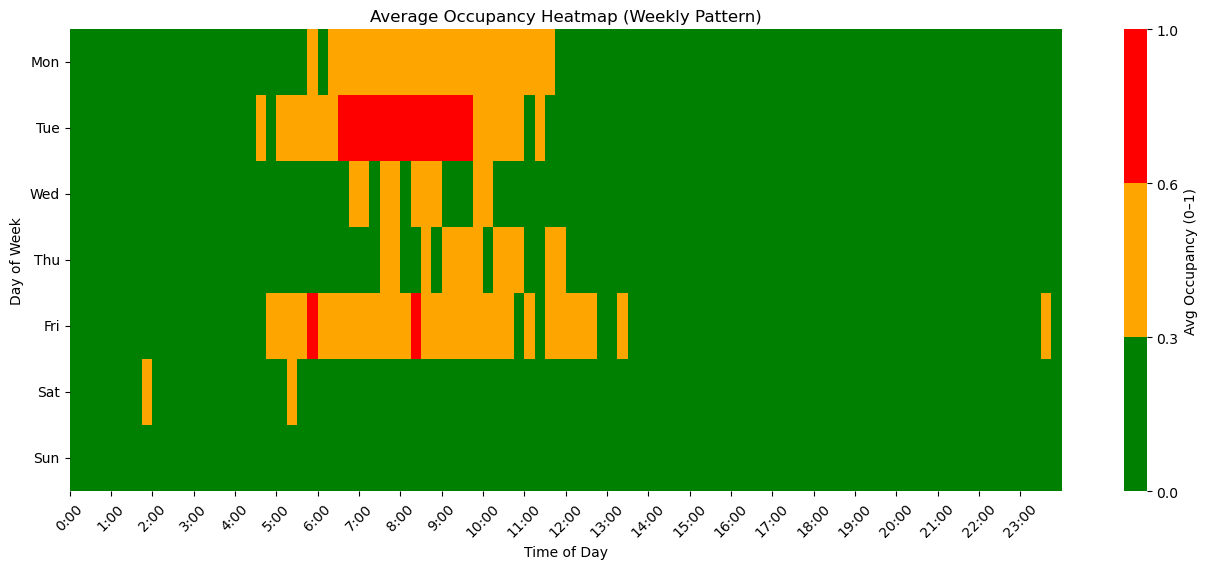

In [7]:
# You can set your own colors here
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.6, 1]  # The thresholds of the boundaries
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(16,6))
sns.heatmap(
    heatmap_data,
    cmap=cmap,
    norm=norm,
    vmin=0, vmax=1, 
    cbar_kws={'label': 'Avg Occupancy (0–1)'}
)

plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

plt.show()

In this section, we explore how different threshold settings affect the interpretation of occupancy levels. Each heatmap uses the same three-color scheme (green, orange, red) but applies different boundary values to define what is considered low, medium, and high occupancy. By testing multiple scenarios, ranging from very risk-averse (low thresholds) to optimistic (high thresholds), we can observe how sensitive the visualized patterns are to these assumptions. This helps determine which categorization best represents realistic availability for logistics users, depending on how strictly or loosely occupancy levels should be interpreted.

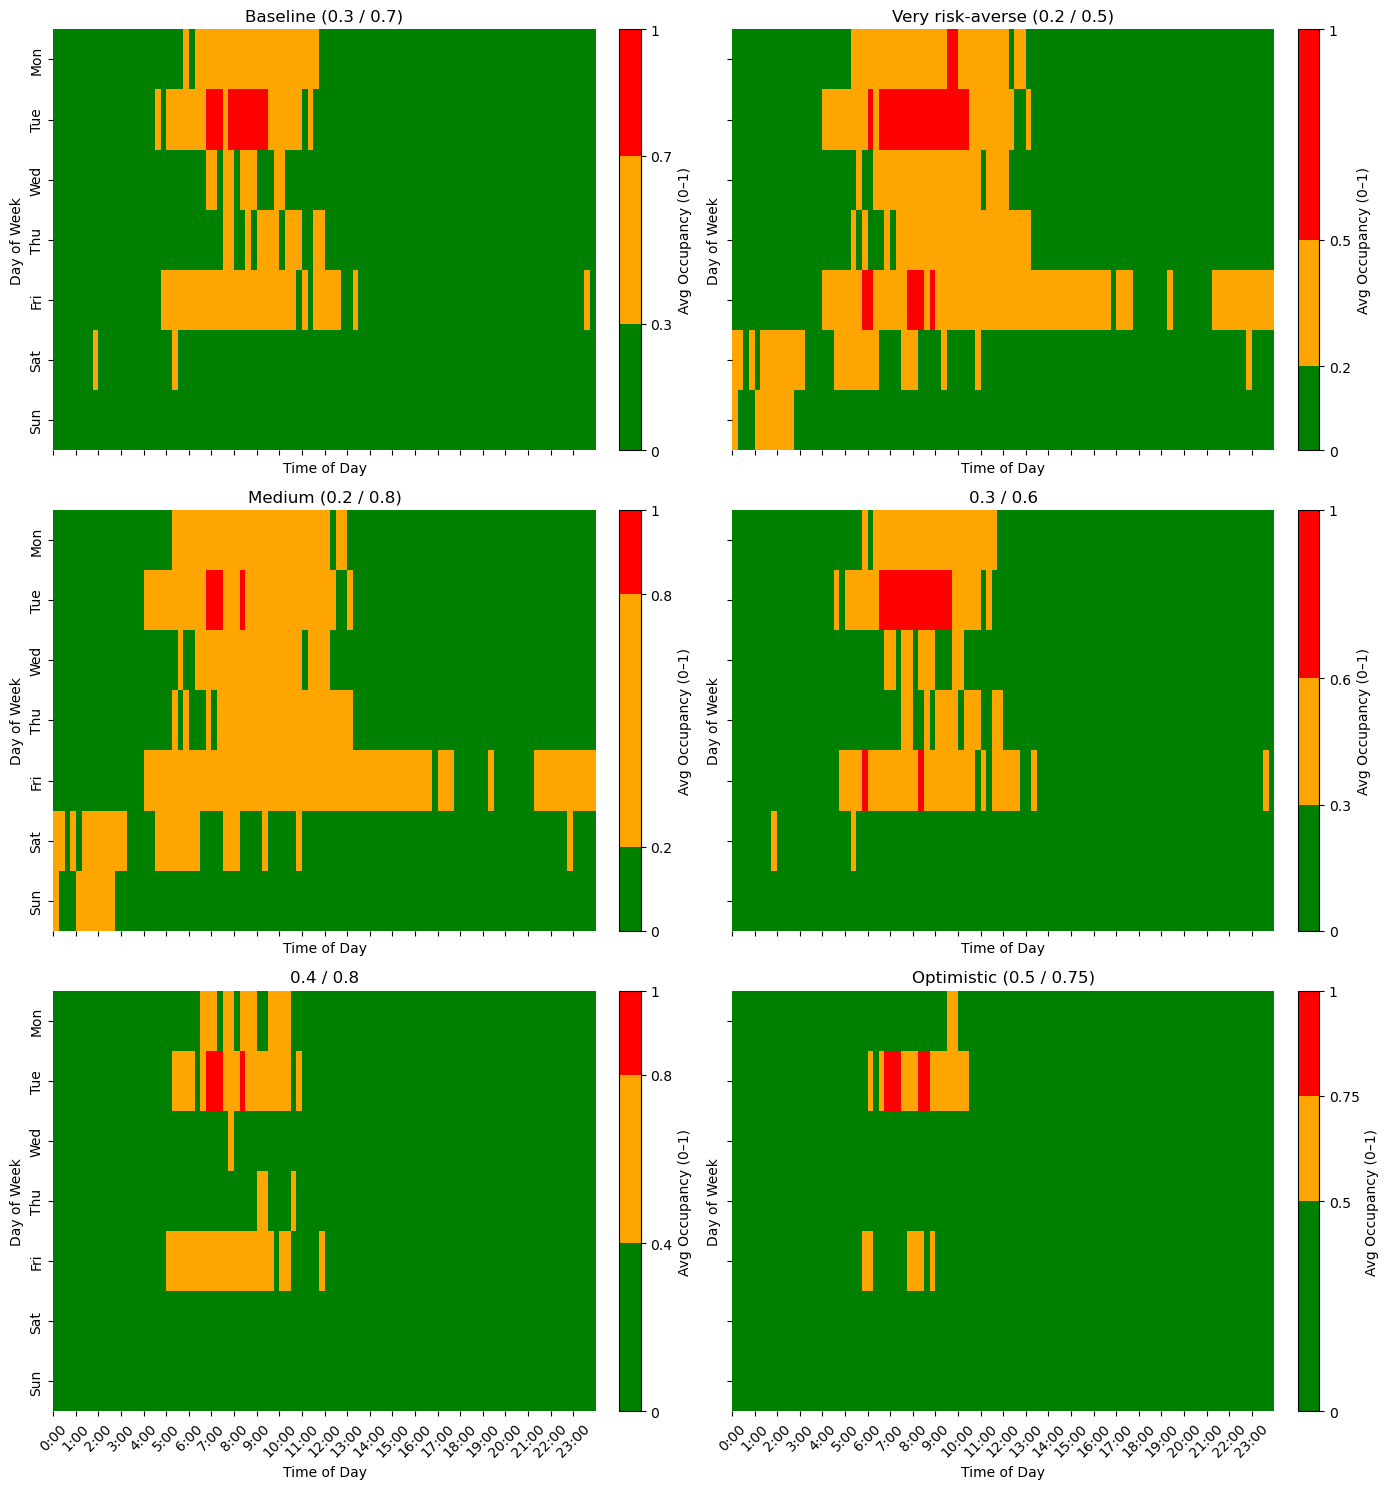

In [ ]:
# Here you can set your own colors
colors = ["green", "orange", "red"]

data_plot = heatmap_data.astype(float)
cmap = ListedColormap(colors)

# 6 scenario's + names
boundaries_list = [
    [0.0, 0.3, 0.6, 1.0],   # baseline
    [0.0, 0.2, 0.5, 1.0],   # very risk-averse
    [0.0, 0.2, 0.8, 1.0],   # medium
    [0.0, 0.3, 0.7, 1.0],   # strong around 0.7
    [0.0, 0.4, 0.8, 1.0],   # simpler
    [0.0, 0.5, 0.75, 1.0],  # optimistic
]
scenario_names = [
    "Baseline (0.3 / 0.6)",
    "Very risk-averse (0.2 / 0.5)",
    "Medium (0.2 / 0.8)",
    "0.3 / 0.7",
    "0.4 / 0.8",
    "Optimistic (0.5 / 0.75)",
]

rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), sharex=True, sharey=True, squeeze=False)

for ax, bounds, name in zip(axes.ravel(), boundaries_list, scenario_names):
    norm = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

    hm = sns.heatmap(
        data_plot,
        cmap=cmap,
        norm=norm,
        vmin=0, vmax=1,       
        ax=ax,
        cbar=False,
        linewidths=0
    )

    cbar = fig.colorbar(
        hm.collections[0],
        ax=ax,
        boundaries=bounds,
        ticks=bounds,                 
        spacing='proportional',       
        fraction=0.046, pad=0.04
    )
    cbar.ax.set_yticklabels([f"{b:g}" for b in bounds])
    cbar.set_label("Avg Occupancy (0–1)")

    ax.set_title(name)
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")
    ax.set_xticks(np.arange(0, 96, 4))
    ax.set_xticklabels([f"{i}:00" for i in range(24)], rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])

plt.tight_layout()
plt.show()

To make the occupancy patterns easier to interpret, we also visualized the data in the same format used by Google’s “Popular Times” feature. Each bar chart represents one day of the week, showing the average occupancy in 15-minute intervals throughout the day. This visualization makes it easier to identify the most and least busy times at a glance. Compared to the heatmaps, these plots provide a more straightforward day-by-day view of occupancy level and help highlight recurring daily peaks and quiet periods. 

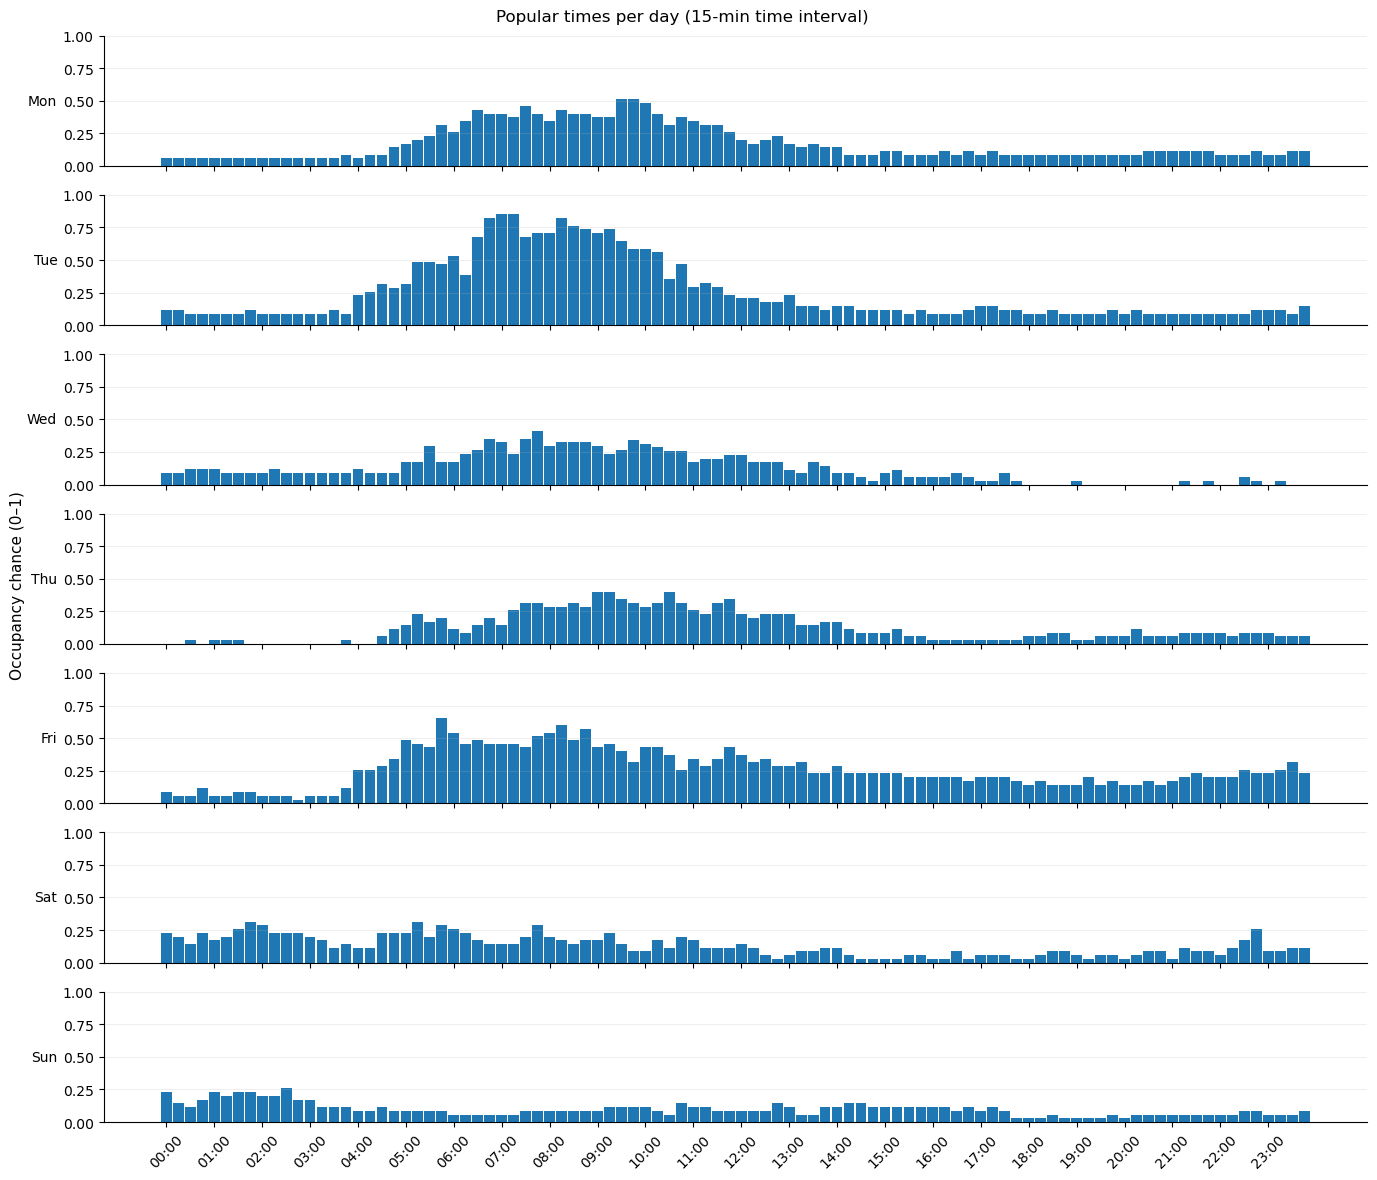

In [9]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_data.loc[d].values.astype(float)  
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                       
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

Lastly, we analyzed the data to explore potential monthly variations in occupancy. However, since the dataset only covers a single year, we cannot identify or compare true yearly or holiday-related trends, such as those around Christmas, Easter, or summer vacations. The plots below therefore show each available month separately to highlight any short-term or intra-year differences that might still be observed. 

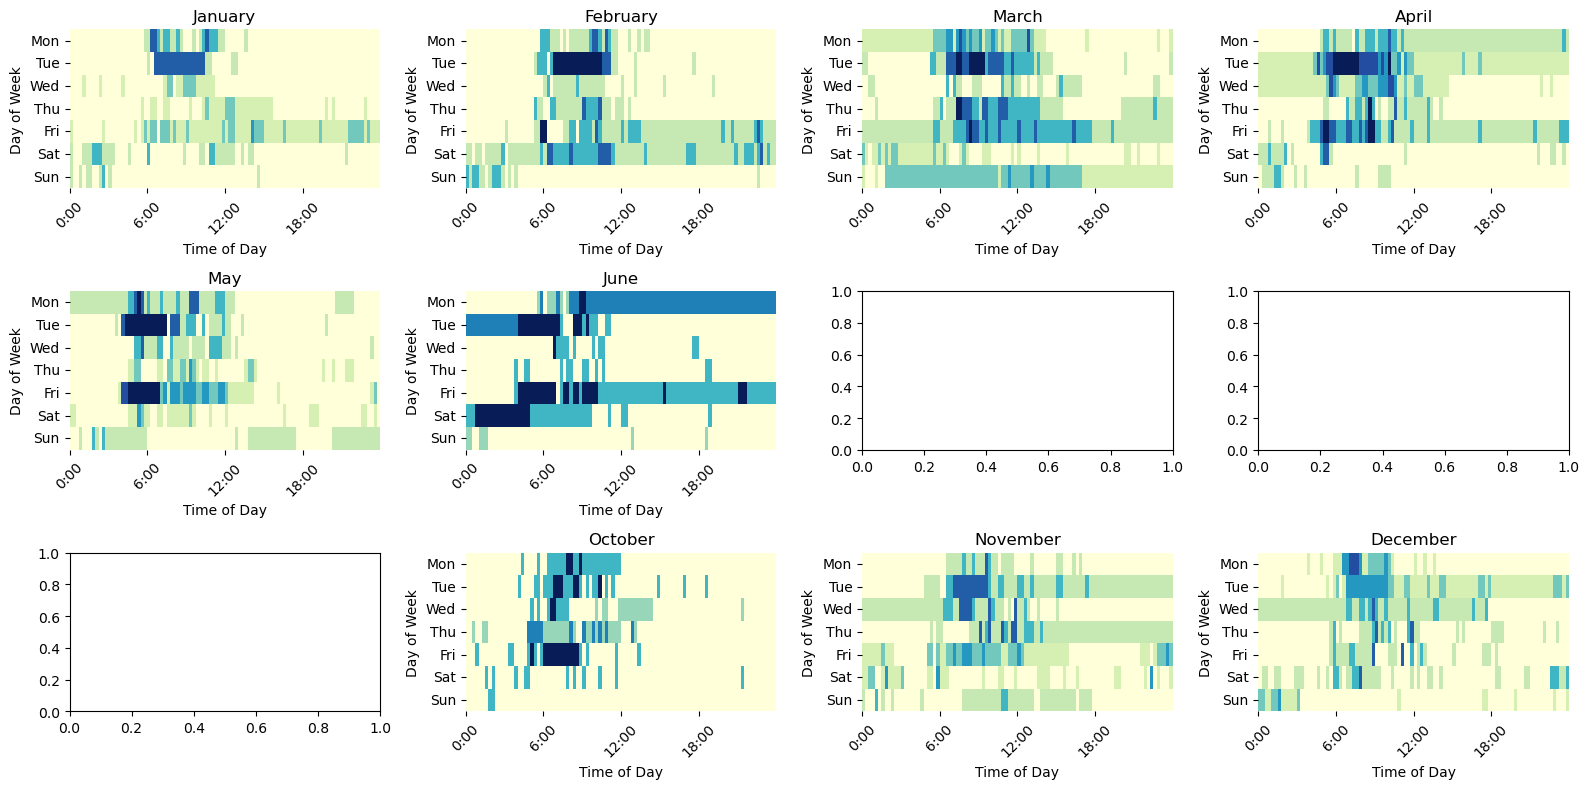

In [10]:
data['month'] = data['date'].dt.month  

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for month in range(1, 13):
    heatmap_data = data[data['month'] == month].copy()

    if heatmap_data.empty:
        continue  

    heatmap_data = heatmap_data.sort_values('date')
    heatmap_data = heatmap_data.drop_duplicates(subset='date', keep='first')
    heatmap_data = (
        heatmap_data.set_index('date')
        .resample('15min')
        .ffill()
        .reset_index()
    )
    heatmap_data['day_of_week'] = heatmap_data['date'].dt.dayofweek
    heatmap_data['slot'] = heatmap_data['date'].dt.hour * 4 + heatmap_data['date'].dt.minute // 15

    heatmap_data = (
        heatmap_data.groupby(['day_of_week', 'slot'])['status']
        .mean()
        .unstack()
        .astype(float)
    )
    
    ax = axes[month - 1]
    sns.heatmap(heatmap_data, cmap="YlGnBu", vmin=0, vmax=1, cbar=False, ax=ax)
    ax.set_title(pd.to_datetime(f'2024-{month:02d}-01').strftime('%B'))
    ax.set_xlabel("Time of Day")
    ax.set_ylabel("Day of Week")

    xticks = np.arange(0, 96, 24) 
    xlabels = [f"{i}:00" for i in range(0, 24, 6)]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yticks(np.arange(0.5, 7.5))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)

plt.tight_layout()
plt.show()

## Feature engineering
Preparing the data to use for the XGBoost model. We make some extra values namely:

- 15-min timeslots, changes the dataset so we have a new dataset for all of the 15 min intervals inbetween the first timeslot we have in the dataset, to the last date. 
- Rolling windows, for window sizes of 1 hour, 3 hours, 6 hours, 1 day and 1 week. You can add extra windows, but don't forget to add them to the used features later in the notebook.
- Lag features, how far back should the model look. Meaning a lag of 1 looks at the 15 min interval before. A lag of 2 looks at the interval 2 back, 12 looks at the slot 3 hours back, 96 looks at the slot one day back and 672 looks at the same timeslot but one week ago.
- Is weekend, this is 1 of it is Saturday or Sunday and 0 otherwise. 




In [11]:
# Rolling features
rolling_windows = {
    '1h': 4,
    '3h': 12, 
    '6h': 24, 
    '1d': 96, 
    '1w': 672
}

# Lag features
lags = [1, 2, 3, 4, 12, 24, 96, 672]

def load_data_for_zone(smartzone, dataset):
    # Copy original dataset
    data = dataset.copy()
    data = data[data['location name'] == smartzone]

    # Ensure integer status
    data['status'] = data['status'].astype(float)

    # Regularize timeseries
    data = data.sort_values('date')
    data = data.drop_duplicates(subset='date', keep='first')
    data = data.set_index('date').resample('15min').ffill().reset_index()

    # Time features
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['day_of_month'] = data['date'].dt.day
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['slot'] = data['date'].dt.hour * 4 + data['date'].dt.minute // 15
    data['time_of_day'] = data['slot'] / 96
    data['dow_slot'] = data['day_of_week'].astype(str) + "_" + data['slot'].astype(str)

    for lag in lags:
        data[f'status_lag_{lag}'] = data['status'].shift(lag)

    for name, window in rolling_windows.items():
        data[f'status_roll_mean_{name}'] = data['status'].rolling(window).mean().shift(1)
        data[f'status_roll_max_{name}'] = data['status'].rolling(window).max().shift(1)
        data[f'status_roll_min_{name}'] = data['status'].rolling(window).min().shift(1)
        data[f'status_roll_sum_{name}'] = data['status'].rolling(window).sum().shift(1)

    # Drop NaNs after lag/rolling
    data = data.dropna().reset_index(drop=True)

    return data

data_with_features = load_data_for_zone(smartzone, dataset)


## Model training
Selecting which features to use. In case you added extra features to the dataset, you should add them in here as well. Otherwise the model won't consider them. 

In [12]:
features = [
    'day_of_week','month','day_of_month','is_weekend','time_of_day','dow_slot',
    'status_lag_1','status_lag_2','status_lag_3','status_lag_4',
    'status_lag_12','status_lag_24','status_lag_96', 'status_lag_672',
    'status_roll_mean_1h','status_roll_max_1h','status_roll_min_1h','status_roll_sum_1h',
    'status_roll_mean_3h','status_roll_max_3h','status_roll_min_3h','status_roll_sum_3h',
    'status_roll_mean_6h','status_roll_max_6h','status_roll_min_6h','status_roll_sum_6h',
    'status_roll_mean_1d','status_roll_max_1d','status_roll_min_1d','status_roll_sum_1d',
    'status_roll_mean_1w','status_roll_max_1w','status_roll_min_1w','status_roll_sum_1w'
]

## Model selection
Like already stated we use the XGBoost model as a regression. 

In this part we create the model, split the dataset into train and test set. Where the first 80% of data, sorted on date, is for the train set and the last 20% for the testset. 

In [13]:
def get_model(data_set, max_depth=4, n_estimators=300, learning_rate=0.01):
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        enable_categorical=True,
        random_state=42,
    )
    
    X = data_set[features].copy()
    X['dow_slot'] = X['dow_slot'].astype('category')

    y = data_set['status'].astype(float)  # regression target (probability 0–1)

    # Train/test split (last 20% is test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    model.fit(X_train, y_train)
    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred,0,1)

    return model, X, X_train, X_test, y_pred, y_train, y_test


model, X, X_train, X_test, y_pred, y_train, y_test = get_model(data_with_features)


# Feature Selection Techniques
Some plots that show the importance of the features and checking if the features are contributing enough to keep in the model.

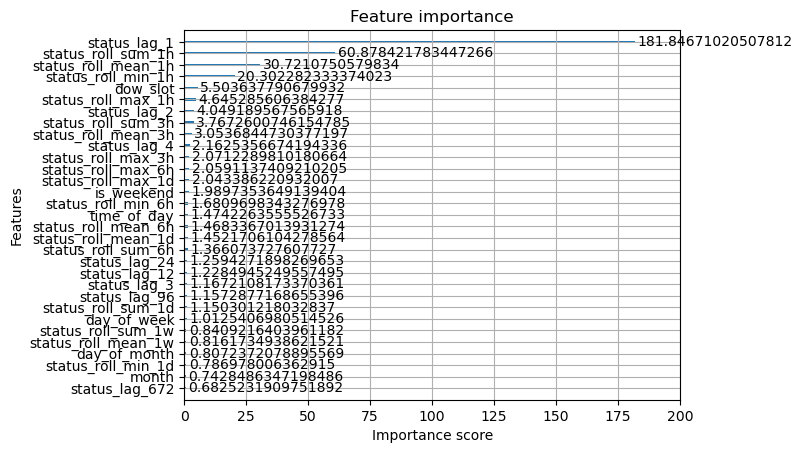

In [14]:
xgb.plot_importance(model, importance_type='gain', max_num_features=35)
plt.show()

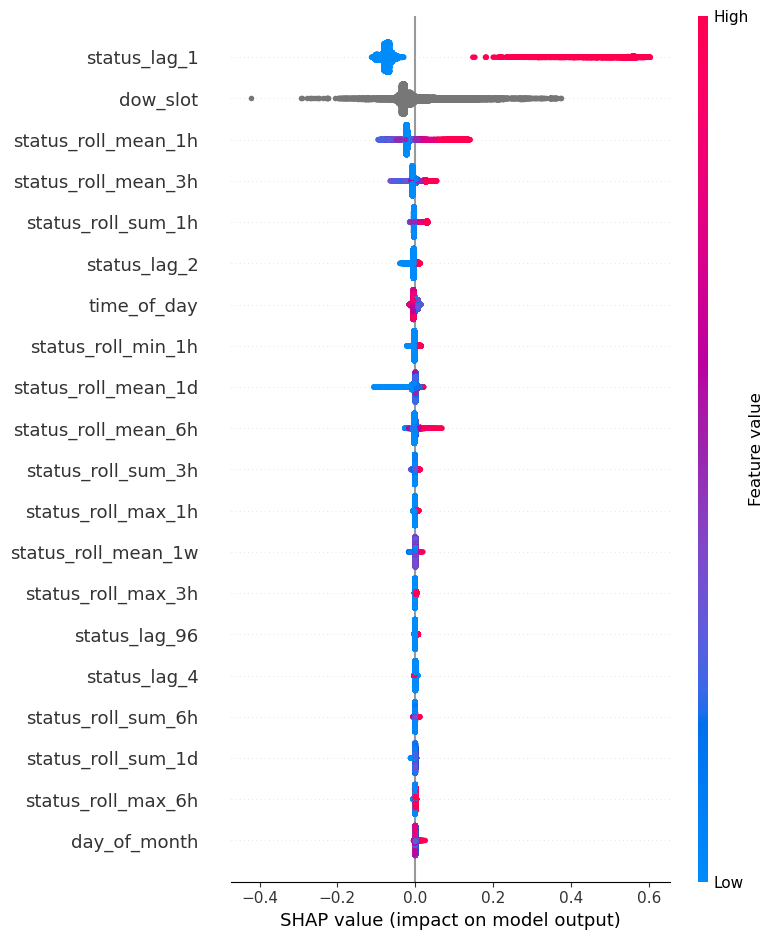

In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

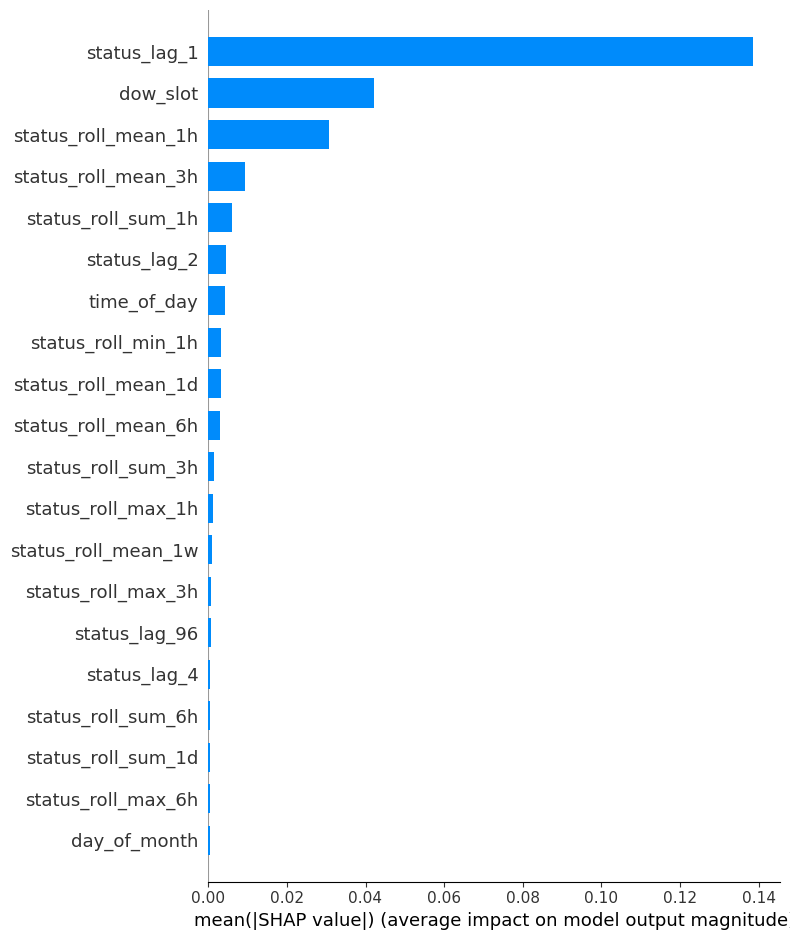

In [16]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


## Model evaluation
evaluating the model using the ROC AUC score, RMSE and MAE values. 

We want the ROC AUC score to be as close to 1 as possible and the RMSE and MAE to be as close to 0 as possible.

In [17]:

# Hyperparameters tuning by grid search approach
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500]
}
# Change cv to 3 for faster tuning.
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best scores:", grid_search.best_score_)
# Rank the tuning results 
results_df = pd.DataFrame(grid_search.cv_results_)
params_df = results_df['params'].apply(pd.Series)
comparison_table = pd.concat([results_df, params_df], axis=1).drop(columns=['params']).sort_values('mean_test_score', ascending=False)
# Re-train the best model
best_model = grid_search.best_estimator_
model = best_model

Best parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Best scores: -0.057078682801879964


In [18]:
# show the tuning rank
comparison_table[['learning_rate', 'max_depth', 'n_estimators', 'mean_test_score']]

,learning_rate,max_depth,n_estimators,mean_test_score
1,0.01,4.0,300.0,-0.057079
2,0.01,4.0,500.0,-0.057753
9,0.05,4.0,100.0,-0.057866
18,0.10,4.0,100.0,-0.059407
4,0.01,6.0,300.0,-0.059685
10,0.05,4.0,300.0,-0.059829
5,0.01,6.0,500.0,-0.060738
12,0.05,6.0,100.0,-0.061454
7,0.01,8.0,300.0,-0.061546
11,0.05,4.0,500.0,-0.061583


In [19]:
# Evaluate
def evaluation(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return roc_auc, rmse, mae

roc_auc, rmse, mae = evaluation(y_test, y_pred)

print(f"Tests: ROC AUC: {roc_auc:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} ")

Tests: ROC AUC: 0.9375 | RMSE: 0.2411 | MAE: 0.1181 


## Results visualization
Heatmap of the test set data, showing the average occupancy of the spot in 15-min intervals in the specific smartzone.

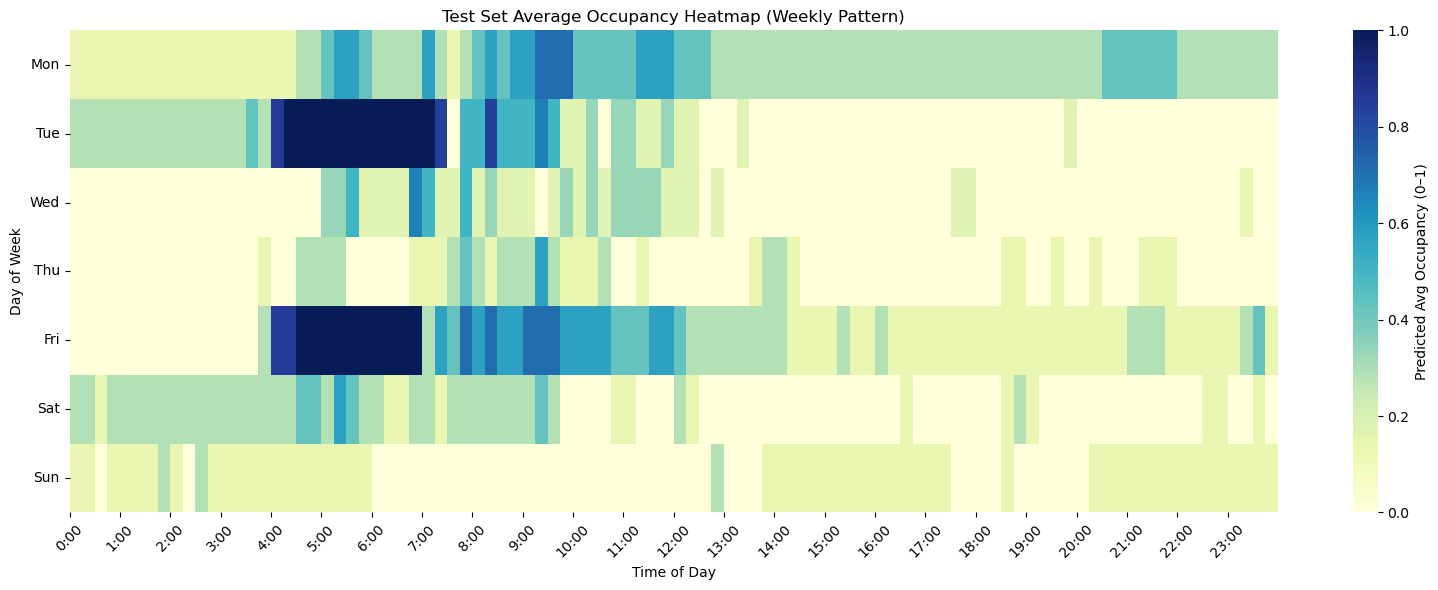

In [20]:
X_test["occupancy"] = y_test

X_test['slot'] = X_test['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    X_test.groupby(["day_of_week", "slot"])["occupancy"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Test Set Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Heatmap of the predicted data, showing the predicted occupancy of the spot in the 15-min slots in Neude. We want this heatmap to look like the plot above, so the average occupancy heatmap of the test set. 

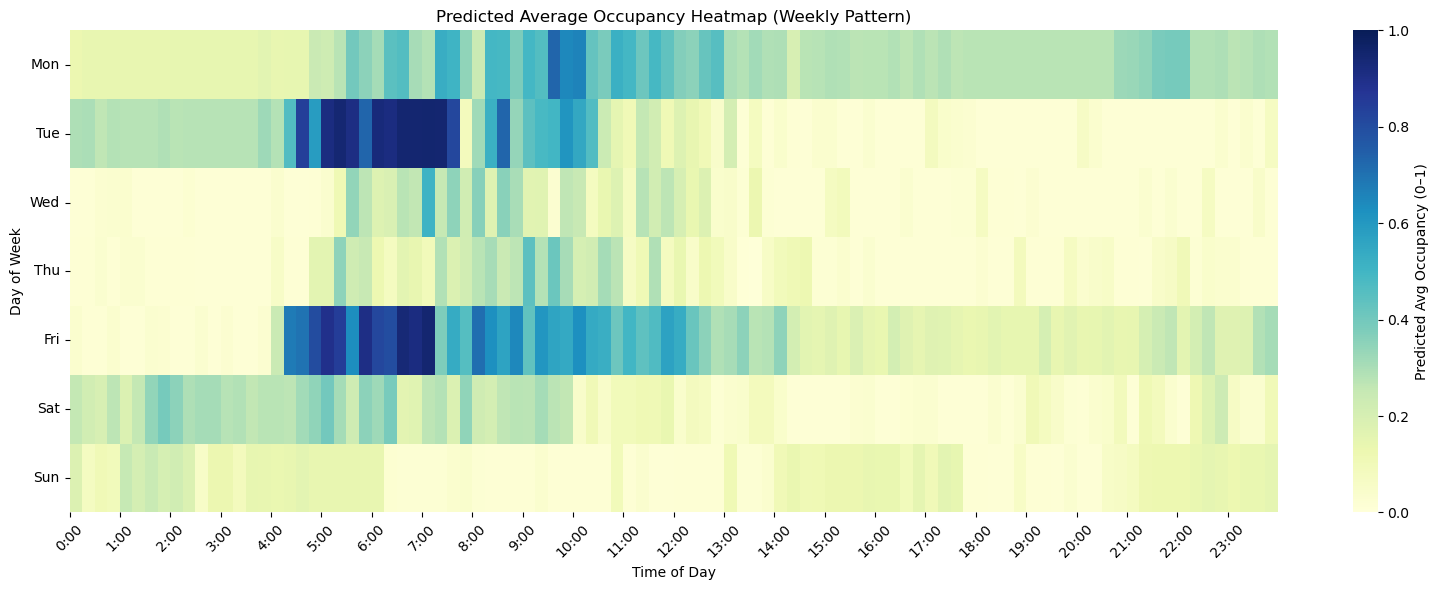

In [21]:

data_pred = X_test.copy()
data_pred["prediction"] = y_pred

data_pred['slot'] = data_pred['dow_slot'].astype(str).str.split("_").str[1].astype(int)

heatmap_pred = (
    data_pred.groupby(["day_of_week", "slot"])["prediction"]
    .mean()
    .unstack()
)

# Plot
plt.figure(figsize=(16,6))
sns.heatmap(heatmap_pred, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label': 'Predicted Avg Occupancy (0–1)'})
plt.xlabel("Time of Day")
plt.ylabel("Day of Week")
plt.title("Predicted Average Occupancy Heatmap (Weekly Pattern)")

xticks = np.arange(0, 96, 4)
xlabels = [f"{i}:00" for i in range(24)]
plt.xticks(xticks, xlabels, rotation=45)
plt.yticks(np.arange(0.5, 7.5), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Lineplot of the predicted occupancy against the true occupancy in the test set for average occupancy in the selected smartzone.

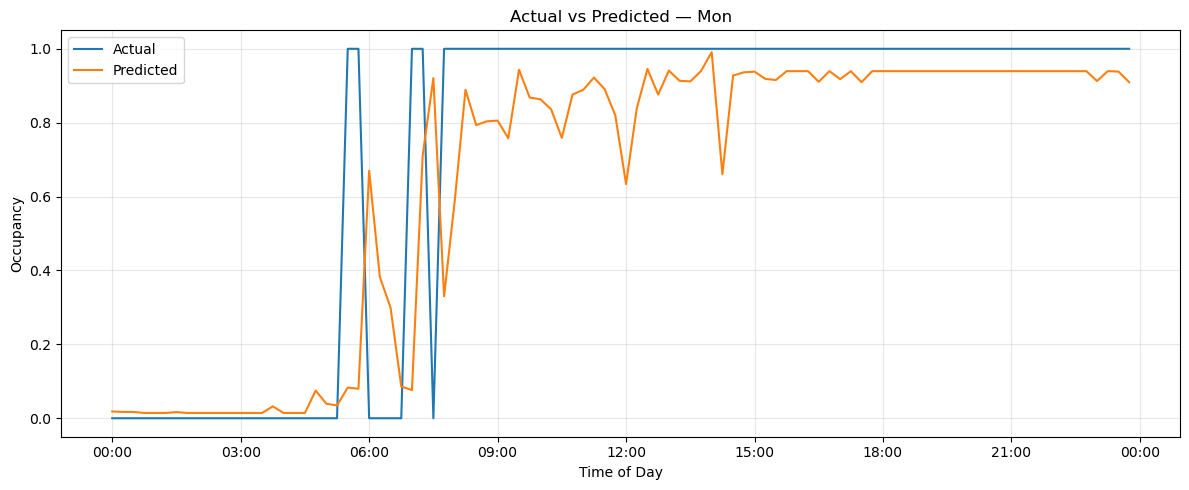

In [22]:
df = X_test.copy()
df["y_true"] = y_test
df["y_pred"] = y_pred

df[["day_of_week","slot"]] = (
    df["dow_slot"].astype(str).str.split("_", expand=True).astype(int)
)

dow = 0
dom = 16
m = 6

day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
title_day = day_names[dow]

day_df = (df[(df["day_of_week"] == dow) & (df["day_of_month"] == dom) & (df["month"] == m)]
          .groupby("slot")[["y_true","y_pred"]]
          .mean()
          .reset_index()
          .sort_values("slot"))

time_base = pd.to_datetime("2000-01-01")  # arbitraire datum
day_df["time"] = time_base + pd.to_timedelta(day_df["slot"] * 15, unit="m")

plt.figure(figsize=(12,5))
plt.plot(day_df["time"], day_df["y_true"], label="Actual")
plt.plot(day_df["time"], day_df["y_pred"], label="Predicted")
plt.title(f"Actual vs Predicted — {title_day}")
plt.xlabel("Time of Day")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.tight_layout()
plt.show()

## Forecasting for Dashboard
Here we made a forcasting for a week in advance so that we can later use this in the dashboard. 

In [23]:
def get_forecasting_df(X, model, data):
    dow_slot_cats = X['dow_slot'].cat.categories  

    max_lag = max(lags)
    hist = data.copy().reset_index(drop=True)
    hist_needed = hist.tail(max(672, max_lag) )   

    hist_status = hist_needed['status'].to_numpy()
    start_ts = hist_needed['date'].iloc[-1]

    H = 96 * 7  # 1 week in advance in 15-min slots
    pred_ts, pred_vals = [], []

    for k in range(0, H):
        ts   = start_ts + pd.Timedelta(minutes=15 * k)
        slot = ts.hour * 4 + ts.minute // 15
        dow  = ts.dayofweek

        feats = {
            'day_of_week': dow,
            'month': ts.month,
            'day_of_month': ts.day,
            'is_weekend': int(dow >= 5),
            'time_of_day': slot / 96,
            'dow_slot': f"{dow}_{slot}",
        }

        for L in lags:
            idx = -(L - k) - 1
            if idx < -len(hist_status):
                feats[f'status_lag_{L}'] = np.nan
            else:
                feats[f'status_lag_{L}'] = float(hist_status[idx])

        for name, win in rolling_windows.items():
            recent = hist_status[-win:] if len(hist_status) >= win else hist_status
            feats[f'status_roll_mean_{name}'] = np.mean(recent) #np.nan
            feats[f'status_roll_max_{name}']  = np.max(recent) #np.nan
            feats[f'status_roll_min_{name}']  = np.min(recent) #np.nan
            feats[f'status_roll_sum_{name}']  = np.sum(recent) #np.nan

        Xp = pd.DataFrame([feats])[features]
        Xp['dow_slot'] = pd.Categorical(Xp['dow_slot'], categories=dow_slot_cats)

        p = model.predict(Xp)[0]

        pred_ts.append(ts)
        pred_vals.append(np.clip(p, 0, 1))

    forecast_df = pd.DataFrame({'date': pred_ts, 'status_pred': pred_vals})
    return forecast_df

forecast_df = get_forecasting_df(X, model, data_with_features)


This creates the heatmap of the forecasted data that can be shown in the dashboard.

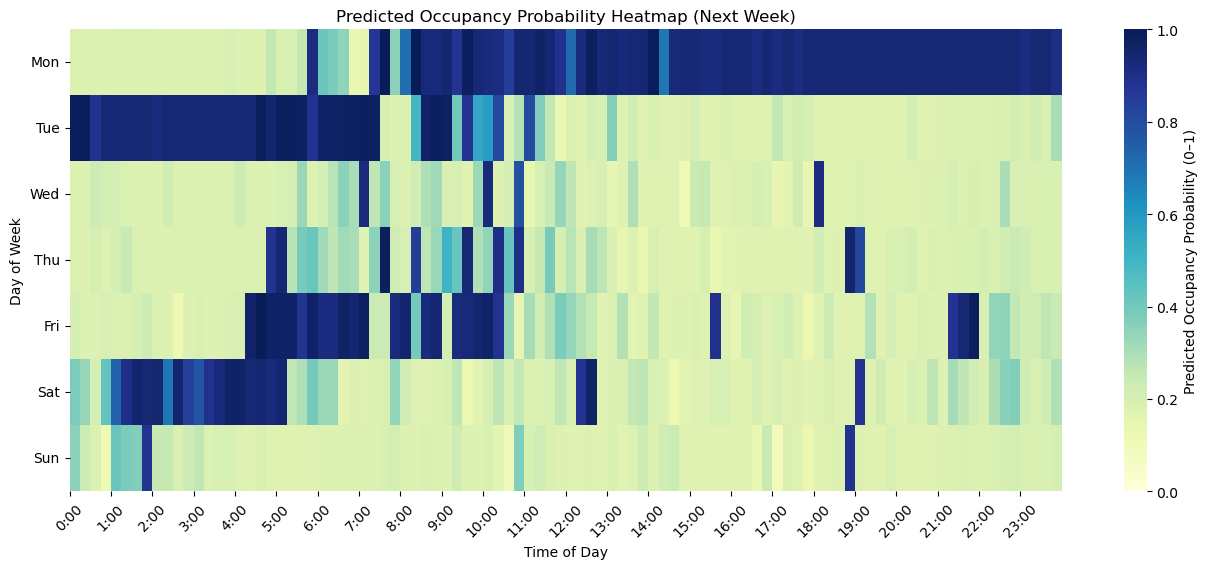

In [24]:
def get_forecast_heatmap(forecast_df):
    forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
    forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

    heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

    plt.figure(figsize=(16,6))
    sns.heatmap(heatmap_matrix, cmap="YlGnBu", vmin=0, vmax=1, cbar_kws={'label':'Predicted Occupancy Probability (0–1)'})
    plt.xlabel("Time of Day")
    plt.ylabel("Day of Week")
    plt.title("Predicted Occupancy Probability Heatmap (Next Week)")
    xticks = np.arange(0, 96, 4)
    xlabels = [str(i)+":00" for i in range(24)]
    plt.xticks(xticks, xlabels, rotation=45)
    plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
    plt.show()

get_forecast_heatmap(forecast_df)

The forecasted occupancy of the smartzone in a heatmap, but in 3 colors.

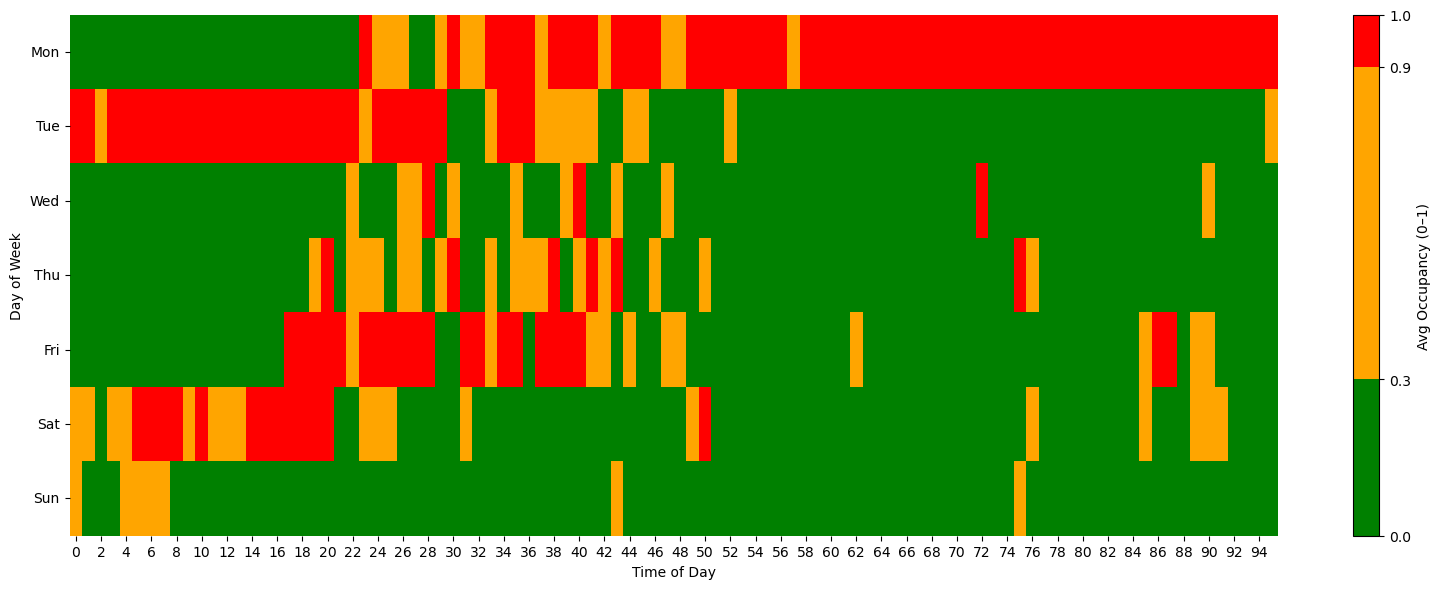

In [25]:
colors = ["green", "orange", "red"]
bounds = [0, 0.3, 0.9, 1]  
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['slot'] = forecast_df['date'].dt.hour * 4 + forecast_df['date'].dt.minute // 15

heatmap_matrix = forecast_df.groupby(['day_of_week','slot'])['status_pred'].mean().unstack()

fig, ax = plt.subplots(figsize=(16,6))
hm = sns.heatmap(
    heatmap_matrix,
    cmap=cmap,
    norm=norm,
    vmin = 0, vmax = 1,
    ax = ax,
    cbar = False
)

cbar = fig.colorbar(
    hm.collections[0],
    ax=ax,
    boundaries=bounds,
    ticks=bounds,                
    spacing='proportional'       
)
cbar.set_label("Avg Occupancy (0–1)")

cbar.ax.set_yticklabels([f"{b:.1f}" for b in bounds])
ax.set_xlabel("Time of Day")
ax.set_ylabel("Day of Week")
plt.yticks(np.arange(0.5,7.5), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)
plt.tight_layout()
plt.show()

Boxplot of the forcasted occupancy of the smartzone. 

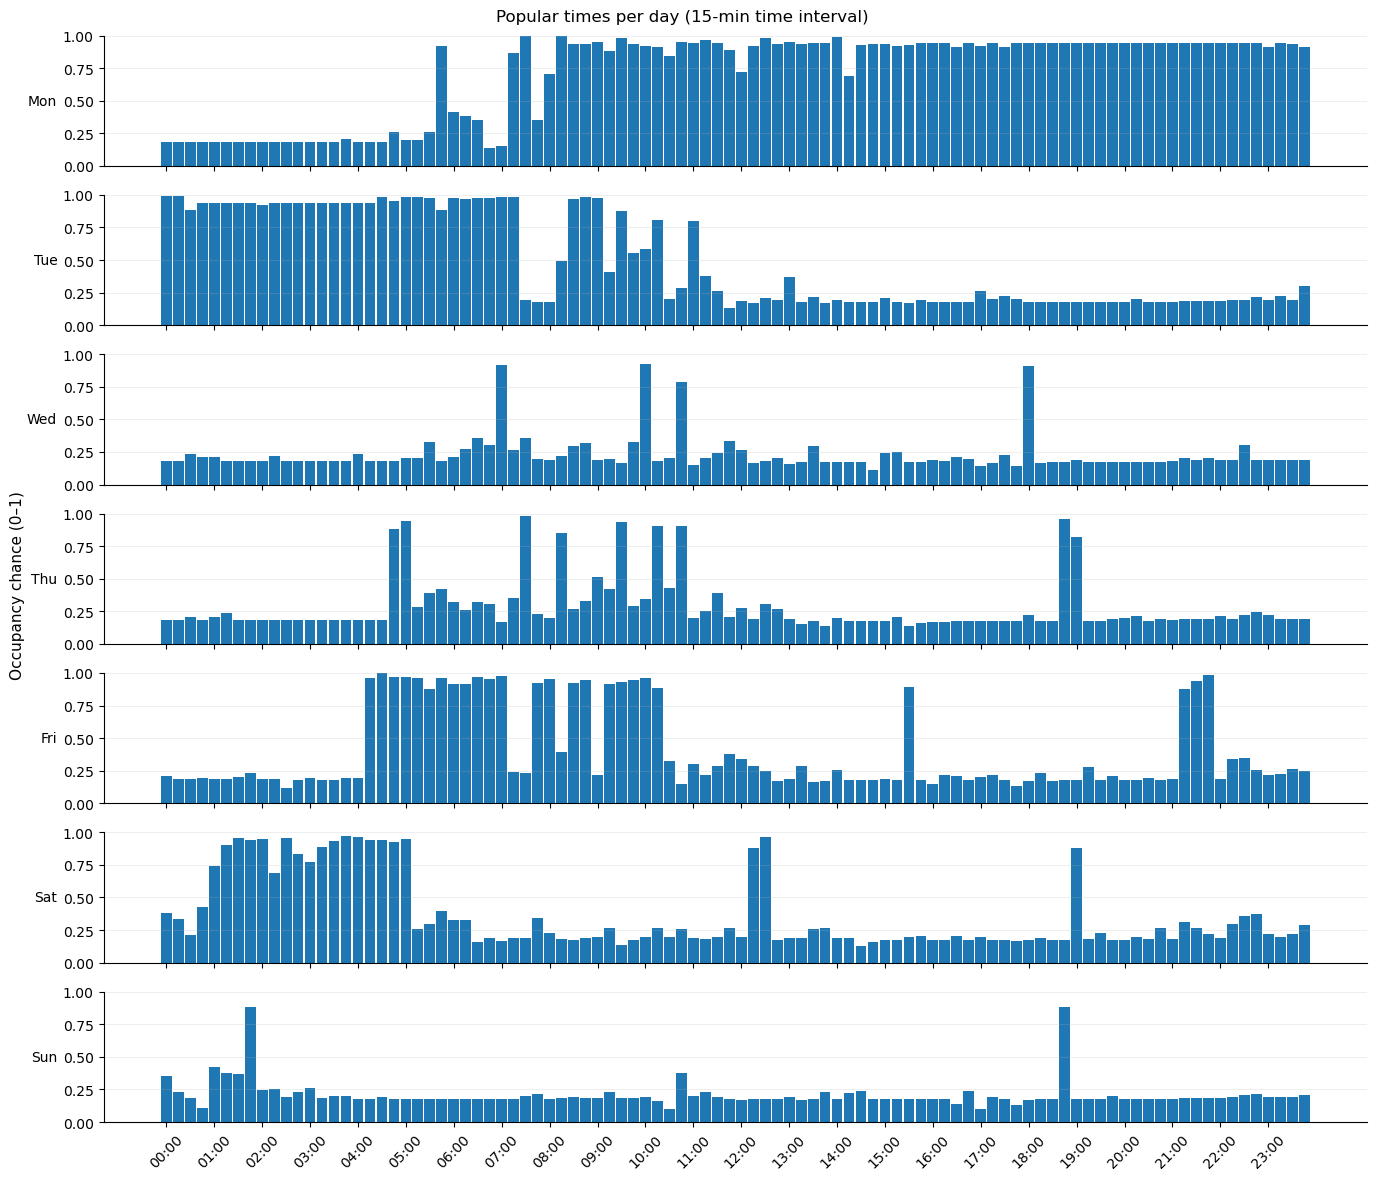

In [26]:
day_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

fig, axes = plt.subplots(7, 1, figsize=(14, 12), sharex=True, sharey=True)

for d in range(7):
    ax = axes[d]
    y = heatmap_matrix.loc[d].values.astype(float)   
    x = np.arange(96)

    ax.bar(x, y, width=0.9)                        
    ax.set_ylim(0, 1)
    ax.set_ylabel(day_names[d], rotation=0, ha="right", va="center")
    ax.grid(axis="y", linewidth=0.5, alpha=0.3)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

hour_ticks = np.arange(0, 96, 4)
hour_labels = [f"{h:02d}:00" for h in range(24)]
axes[-1].set_xticks(hour_ticks)
axes[-1].set_xticklabels(hour_labels, rotation=45)

fig.suptitle("Popular times per day (15-min time interval)")
fig.supylabel("Occupancy chance (0–1)", fontsize=11)
fig.tight_layout()
plt.show()

# Dashboard Integration

This is a low quality version of the integration of our forecasting model of the smartzone into the dashboard of Coding the Curbs their dashboard. In the presentation we show a higher quality version.

We can select the smartzone in this dashboard by using the dropdown menu. After selecting the smartzone, the model starts training and after training and evaluating, it shows the evaluation. Then it starts forcasting for a week in advance and it shows the results of the forecast in a heatmap in the dashboard. 

In [27]:
smartzone_dropdown = widgets.Dropdown(
    options = list(get_locations(dataset)),
    description='Smartzone:'
)

output = widgets.Output()

def on_zone_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output()
            zone_widget = change['new']
            data_widget = load_data_for_zone(zone_widget, dataset)
            model_widget, Xt, X_train, X_test, y_pred, y_train, y_test = get_model(data_widget)
            roc_auc, rmse, mae = evaluation(y_test, y_pred)

            print(f"Model Evaluation on Smartzone:")
            print(f"  ROC-AUC: {roc_auc:.3f}")
            print(f"  RMSE:    {rmse:.3f}")
            print(f"  MAE:     {mae:.3f}\n")

            preds = get_forecasting_df(Xt, model_widget, data_widget)
            get_forecast_heatmap(preds)

smartzone_dropdown.observe(on_zone_change)
display(smartzone_dropdown, output)

Dropdown(description='Smartzone:', options=('Lange Viestraat', 'Stadhuisplein', 'Domplein', "'t Wed", 'Beurskw…

Output()